# Introduction


Welcome to Domain Data Preparation - ETL on a framework project. This project needs significant manipulation of large-ish raw data, and some non-trivial metadata extraction and storage (e.g., running toolkit on every text in a corpus)


### Project objectives
- [Use HTTP request to retrieve data from RESTful API](#Part-1-Use-HTTP-request-to-retrieve-data-from-RESTful-API)
- [Use web scraper (beautifulsoup) to retrieve data from HTML code](#Part-2-Use-web-scraper-to-retrieve-data-from-HTML-code)
- [Use PyPDF2 to retrieve data from pdf file](#Part-3-Use-PyPDF2-to-retrieve-data-from-pdf-file)

## Part 1 Use HTTP request to retrieve data from RESTful API

In this part, you will need to try to conduct data collection by retrieving data from a RESTful API -- the Twitter API.

When it comes to collect data, social media is always a good place to get data and conduct some analysis. And Twitter is especially worth getting in touch with. Since Twitter has about 48.35 million monthly active users in the US, and nearly half of these users use Twitter on a daily basis[1], which means that you can get huge amount of data from Twitter given any trending topic. And Twitter's API is so powerful that it realizes different kinds of search requirements and provides you with the information you need.



Reference: [Twitter by the Numbers: Stats, Demographics & Fun Facts](https://www.omnicoreagency.com/twitter-statistics/)

#### Library Documentation

The libraries will be needed in this section are listed below, you might need to install them if you don't have them installed before completing later tasks.

* Standard Library: 
    * [io](https://docs.python.org/2/library/io.html)
    * [re](https://docs.python.org/3/library/re.html)
    * [json](https://docs.python.org/2/library/json.html)
  
* Third Party
    * [pandas](https://pandas.pydata.org/docs/getting_started/index.html)  
    * [requests](http://docs.python-requests.org/en/master/)
    * [Beautiful Soup (version 4)](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
    * [tweepy](http://docs.tweepy.org/en/v3.5.0/index.html)
    * [pytest](https://docs.pytest.org/en/latest/contents.html)
    * [nltk](https://www.nltk.org/)
    * [matplotlib](https://matplotlib.org/)

****

In [5]:
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import requests
from testing.testing import test
from pathlib import Path
import pytest   

### Task 1: Authenticated HTTP Request with the Twitter API

In this part, you will start to get used to the Twitter API. 

##### Get Twitter API Access
In order to use data from the Twitter API, first you need to access to the Twitter API. 
* Create a Twitter account (if you do not have one already)
* Generate consumer API keys, access token, and access token secret(if you haven't already). 

After get your own consumer API keys, access token, and access token secret, you might want to store them in a file locally and whenever you want to use them just read them from local.

In [38]:
def read_api_key(filepath="api_key.txt"):
    """
    Read the Twitter API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        keys and tokens (string): The API Keys and tokens
        
    """
    #Twitter credentials for the app
    keys = Path(filepath).read_text().split("\n")
    consumer_key = keys[0].split(":")[1]
    consumer_secret = keys[1].split(":")[1]
    access_key = keys[2].split(":")[1]
    access_secret = keys[3].split(":")[1]
    return consumer_key,consumer_secret,access_key,access_secret
    pass

#### Task 2: Extract COVID-19 Information from Twitter
Now that with your own consumer API keys, access token, and access token secret, let's try to get to know more about the function of the Twitter API from using it to conduct some basic searches.

The Libray we are going to use here is [Tweepy](http://docs.tweepy.org/en/v3.5.0/index.html). You might to refer to the official document from time to time while finishing the tasks below.



- **Using the search function**

This is useful for most of you seeking Twitter data to get conversations on a particular topic. This method returns a collection of relevant Tweets matching a specified query for all public tweets.

In [10]:
def basic_search_test(basic_search):
    texts = basic_search(read_api_key(),"#COVID-19","2020-04-10",10)
    test.equal(len(texts),10)
    test.true('I’m moving $1B of my Square equity (~28% of my wealth) to #startsmall LLC to fund global COVID-19 relief.'in texts[0])
    test.true('Fully agree with you President @realDonaldTrump.' in texts[1])
    test.true('The deluxe version of Rare' in texts[2])
    test.true("Well, Dr. Birx just said it." in texts[3])
    test.true('SHOCKING: MN Sen &amp; Dr. @drscottjensen' in texts[4])
    test.true('COVID-19 co-morbidities' in texts[5])
    test.true('When Covid-19 first hit America hard last month' in texts[6])
    test.true('A tiger at the Bronx Zoo has tested positive for Covid-19.' in texts[7])
    test.true('January 15: First COVID-19 positive case arrives in USA.' in texts[8])
    test.true('My husband and I are recovering from COVID-19. ' in texts[9])
    
@test
def basic_search(consumer_key,consumer_secret,access_key,access_secret, search_words, date_until,top_n):
    """
    Make an authenticated request to the Twitter API.

    Args:
        keys(string): The API Keys and tokens
        search_words (string): Search term
        date_until(string): Given date tweets need to be created before
        top_n(int): The number of results to try and retrieve 

    Returns:
        tweets (list): list of top_n tweets on Twitter about search_words
        
    """
    #pass twitter credentials to tweepy
    consumer_key,consumer_secret,access_key,access_secret = keys
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    
    #auth = OAuth1(consumer_key, consumer_secret, access_token, access_token_secret
    api = tweepy.API(auth,parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)
    texts = []
    results = api.search(q=search_words, lang="en",until=date_until,result_type="popular",count=top_n)
    for result in results['statuses']:
        texts.append(result['text'])
    return texts
    pass

### TESTING basic_search: PASSED 11/11
###



- **Using tweepy.Cursor**
You probably noticed that when you try to use search( ) function to retrieve information, the information you get back will be in JSON format like this which is difficult to deal with:
```python
json_src = """
{'statuses': [{'created_at': 'Thu Apr 09 04:46:53 +0000 2020',
   'id': 1248110109487591424,
   'id_str': '1248110109487591424',
   'text': 'Fully agree with you President @realDonaldTrump. Times like these bring friends closer. The India-US partnership is… https://t.co/qlj0zliauu',
   'truncated': True,
   'entities': {'hashtags': [],
    'symbols': [],
    'user_mentions': [{'screen_name': 'realDonaldTrump',
      'name': 'Donald J. Trump',
      'id': 25073877,
      'id_str': '25073877',
      'indices': [31, 47]}],
    'urls': [{'url': 'https://t.co/qlj0zliauu',
      'expanded_url': 'https://twitter.com/i/web/status/1248110109487591424',
      'display_url': 'twitter.com/i/web/status/1…',
      'indices': [117, 140]}]},
   'metadata': {'result_type': 'popular', 'iso_language_code': 'en'},
   'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
   'in_reply_to_status_id': None,
   'in_reply_to_status_id_str': None,
   'in_reply_to_user_id': None,
   'in_reply_to_user_id_str': None,
   'in_reply_to_screen_name': None,
   'user': {'id': 18839785,
    'id_str': '18839785',
    'name': 'Narendra Modi',
    'screen_name': 'narendramodi',
    'location': 'India',
    'description': 'Prime Minister of India',
    'url': 'https://t.co/zzYhUUfq6i',
    'entities': {'url': {'urls': [{'url': 'https://t.co/zzYhUUfq6i',
        'expanded_url': 'http://www.narendramodi.in',
        'display_url': 'narendramodi.in',
        'indices': [0, 23]}]},
     'description': {'urls': []}},
    'protected': False,
    'followers_count': 55479775,
    'friends_count': 2367,
    'listed_count': 25724,
    'created_at': 'Sat Jan 10 17:18:56 +0000 2009',
    'favourites_count': 0,
    'utc_offset': None,
    'time_zone': None,
    'geo_enabled': False,
    'verified': True,
    'statuses_count': 26477,
    'lang': None,
    'contributors_enabled': False,
    'is_translator': False,
    'is_translation_enabled': False,
    'profile_background_color': 'F4EDD4',
    'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
    'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
    'profile_background_tile': False,
    'profile_image_url': 'http://pbs.twimg.com/profile_images/1134082549041393672/QbihPzrL_normal.png',
    'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1134082549041393672/QbihPzrL_normal.png',
    'profile_banner_url': 'https://pbs.twimg.com/profile_banners/18839785/1559221352',
    'profile_link_color': '4E7096',
    'profile_sidebar_border_color': 'FFFFFF',
    'profile_sidebar_fill_color': 'D5DFED',
    'profile_text_color': '233863',
    'profile_use_background_image': True,
    'has_extended_profile': True,
    'default_profile': False,
    'default_profile_image': False,
    'following': False,
    'follow_request_sent': False,
    'notifications': False,
    'translator_type': 'regular'},
   'geo': None,
   'coordinates': None,
   'place': None,
   'contributors': None,
   'is_quote_status': True,
   'quoted_status_id': 1247950299408498693,
   'quoted_status_id_str': '1247950299408498693',
   'quoted_status': {'created_at': 'Wed Apr 08 18:11:51 +0000 2020',
    'id': 1247950299408498693,
    'id_str': '1247950299408498693',
    'text': 'Extraordinary times require even closer cooperation between friends. Thank you India and the Indian people for the… https://t.co/aDMD5VmPa8',
    'truncated': True,
    'entities': {'hashtags': [],
     'symbols': [],
     'user_mentions': [],
     'urls': [{'url': 'https://t.co/aDMD5VmPa8',
       'expanded_url': 'https://twitter.com/i/web/status/1247950299408498693',
       'display_url': 'twitter.com/i/web/status/1…',
       'indices': [116, 139]}]},
    'metadata': {'result_type': 'popular', 'iso_language_code': 'en'},
    'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
    'in_reply_to_status_id': None,
    'in_reply_to_status_id_str': None,
    'in_reply_to_user_id': None,
    'in_reply_to_user_id_str': None,
    'in_reply_to_screen_name': None,
    'user': {'id': 25073877,
     'id_str': '25073877',
     'name': 'Donald J. Trump',
     'screen_name': 'realDonaldTrump',
     'location': 'Washington, DC',
     'description': '45th President of the United States of America🇺🇸',
     'url': 'https://t.co/OMxB0x7xC5',
     'entities': {'url': {'urls': [{'url': 'https://t.co/OMxB0x7xC5',
         'expanded_url': 'http://www.Instagram.com/realDonaldTrump',
         'display_url': 'Instagram.com/realDonaldTrump',
         'indices': [0, 23]}]},
      'description': {'urls': []}},
     'protected': False,
     'followers_count': 76909159,
     'friends_count': 47,
     'listed_count': 119214,
     'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
     'favourites_count': 6,
     'utc_offset': None,
     'time_zone': None,
     'geo_enabled': True,
     'verified': True,
     'statuses_count': 50647,
     'lang': None,
     'contributors_enabled': False,
     'is_translator': False,
     'is_translation_enabled': True,
     'profile_background_color': '6D5C18',
     'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
     'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
     'profile_background_tile': True,
     'profile_image_url': 'http://pbs.twimg.com/profile_images/874276197357596672/kUuht00m_normal.jpg',
     'profile_image_url_https': 'https://pbs.twimg.com/profile_images/874276197357596672/kUuht00m_normal.jpg',
     'profile_banner_url': 'https://pbs.twimg.com/profile_banners/25073877/1583212785',
     'profile_link_color': '1B95E0',
     'profile_sidebar_border_color': 'BDDCAD',
     'profile_sidebar_fill_color': 'C5CEC0',
     'profile_text_color': '333333',
     'profile_use_background_image': True,
     'has_extended_profile': False,
     'default_profile': False,
     'default_profile_image': False,
     'following': False,
     'follow_request_sent': False,
     'notifications': False,
     'translator_type': 'regular'},
    'geo': None,
    'coordinates': None,
    'place': None,
    'contributors': None,
    'is_quote_status': False,
    'retweet_count': 110588,
    'favorite_count': 451817,
    'favorited': False,
    'retweeted': False,
    'lang': 'en'},
   'retweet_count': 34888,
   'favorite_count': 178855,
   'favorited': False,
   'retweeted': False,
   'possibly_sensitive': False,
   'lang': 'en'}],
 'search_metadata': {'completed_in': 0.033,
  'max_id': 0,
  'max_id_str': '0',
  'next_results': '?max_id=1248110109487591423&q=%23COVID-19%20since%3A2020-04-08%20until%3A2020-04-10&lang=en&count=1&include_entities=1&result_type=popular',
  'query': '%23COVID-19+since%3A2020-04-08+until%3A2020-04-10',
  'count': 1,
  'since_id': 0,
  'since_id_str': '0'}}
"""
```

And you probably found the maximum number of results to try and retrieve per page is up to 100. Luckily, Tweepy has the Cursor object to help handle these kind of problems, allowing you to use a few lines of code to realize pagination and result parsing.

Let's start with realizing the same function we did before using tweepy.Cursor

In [12]:
def cursor_search_test(cursor_search):
    texts = cursor_search(read_api_key(),"#COVID-19","2020-04-10",10)
    test.equal(len(texts),10)
    test.true('I’m moving $1B of my Square equity (~28% of my wealth) to #startsmall LLC to fund global COVID-19 relief.'in texts[0])
    test.true('Fully agree with you President @realDonaldTrump.' in texts[1])
    test.true('The deluxe version of Rare' in texts[2])
    test.true("Well, Dr. Birx just said it." in texts[3])
    test.true('SHOCKING: MN Sen &amp; Dr. @drscottjensen' in texts[4])
    test.true('COVID-19 co-morbidities' in texts[5])
    test.true('When Covid-19 first hit America hard last month' in texts[6])
    test.true('A tiger at the Bronx Zoo has tested positive for Covid-19.' in texts[7])
    test.true('January 15: First COVID-19 positive case arrives in USA.' in texts[8])
    test.true('My husband and I are recovering from COVID-19. ' in texts[9])
    
@test
def cursor_search(consumer_key,consumer_secret,access_key,access_secret, search_words, date_until,top_n):
    """
    Make an authenticated request to the Twitter API.

    Args:
        keys(string): The API Keys and tokens
        search_words (string): Search term
        date_until(string): Given date tweets need to be created before
        top_n(int): The number of results to try and retrieve 

    Returns:
        tweets (list): list of top_n tweets on Twitter about search_words
        
    """
     #pass twitter credentials to tweepy
    consumer_key,consumer_secret,access_key,access_secret = keys
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    
    api = tweepy.API(auth, wait_on_rate_limit=True)
    tweets = tweepy.Cursor(api.search,
                  q=search_words,
                  lang="en",
                  result_type="popular",
                  until = date_until).items(top_n)
    texts = []
    for t in tweets:
        texts.append(t.text)
    return texts
    pass

### TESTING cursor_search: PASSED 11/11
###



- **Parameterization and Pagination**
Now that you have basic understanding of how to use tweepy.Cursor to retrive interested information, let's try to aquire all of the tweets posted on Twitter about COVID-19.

In [33]:
def all_tweets_search_test(all_tweets_search):
    texts = all_tweets_search(read_api_key(),"#COVID-19","2020-04-05","2020-04-11","popular")
    test.equal(len(texts),54)
    
@test
def all_tweets_search(keys,search_words, date_since,date_until,search_type):
    """
    Make an authenticated request to the Twitter API.

    Args:
        search_words (string): Search term

    Returns:
        total (integer): total number of tweets on Twitter about COVID-19
        tweets (list): list of first five tweets on Twitter about COVID-19
        
    """
    #pass twitter credentials to tweepy
    consumer_key,consumer_secret,access_key,access_secret = keys
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    
    #auth = OAuth1(consumer_key, consumer_secret, access_token, access_token_secret
    api = tweepy.API(auth, wait_on_rate_limit=True)
    data=[]
    for tweet in tweepy.Cursor(api.search,
                               q=search_words,
                               lang="en",
                               result_type=search_type,
                               since = date_since,
                               until = date_until).items():
        data.append(tweet.text)
    return data
    pass

### TESTING all_tweets_search: PASSED 1/1
###



- **Parse the API Responses and Extract the URLs**
If you print out the text you got from the Twitter API, you probably got things like:
```python
'I’m moving $1B of my Square equity (~28% of my wealth) to #startsmall LLC to fund global COVID-19 relief. After we… https://t.co/TtdU7W4SWk',
 'Fully agree with you President @realDonaldTrump. Times like these bring friends closer. The India-US partnership is… https://t.co/qlj0zliauu',
 'The deluxe version of Rare, featuring ‘Boyfriend,’ ‘She’ and ‘Souvenir,’ is out April 9th. You can presave it now a… https://t.co/KhBO4Ryl6Z',
 'Why are Democrats okay with a COVID-19 ID card but fight so hard against voter ID to secure our elections?\n\n🤔',
 'Well, Dr. Birx just said it. Anyone in U.S. who dies with Covid 19, regardless of what else may be wrong, is now be… https://t.co/a8bRDBIUr1',
 'SHOCKING: MN Sen &amp; Dr. @drscottjensen said that he received a 7 pg doc from @mnhealth to fill out death certificate… https://t.co/T8x2VPgNij',
 'Do you know why African-Americans align with so many COVID-19 co-morbidities? Structural racism. Food deserts=unequ… https://t.co/uGnCuHEY1O',
 'When Covid-19 first hit America hard last month, the narrative was that it was the great equalizer, that in such a… https://t.co/UzjM7JBHn0',
 'BREAKING: A tiger at the Bronx Zoo has tested positive for Covid-19. 6 other tigers and lions at the zoo are also s… https://t.co/Wf60DcP1v0'
```

Do you notice? Some of the text returned back is incomplete! The reason why you got this is because the text is folded. If you what to get the full tweet text, you might need to parse the API responses and extract the URLs which will the task of this part. 

Notice: You can identify whether the content of the tweet text is folded by looking at the attribute **truncated** in the response

In fact, you get untruncated tweet text just by modifying a few parameters in the tweepy.Cursor. Take a look at the official document and try to return untruncated tweet text for every result.

In [86]:
def full_text_search_test(full_text_search):
    tweets = full_text_search(read_api_key(),"#COVID-19","2020-04-05","2020-04-11","popular")
    test.equal(tweets[0],'I’m moving $1B of my Square equity (~28% of my wealth) to #startsmall LLC to fund global COVID-19 relief. After we disarm this pandemic, the focus will shift to girl’s health and education, and UBI. It will operate transparently, all flows tracked here: https://t.co/hVkUczDQmz')

@test
def full_text_search(keys,search_words, date_since,date_until,search_type):
    """
    Make an authenticated request to the Twitter API.

    Args:
        search_words (string): Search term

    Returns:
        total (integer): total number of tweets on Twitter about COVID-19
        tweets (list): list of first five tweets on Twitter about COVID-19
        
    """
    #pass twitter credentials to tweepy
    consumer_key,consumer_secret,access_key,access_secret = keys
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    
    #auth = OAuth1(consumer_key, consumer_secret, access_token, access_token_secret
    api = tweepy.API(auth, wait_on_rate_limit=True)
    tweets=[]
    for tweet in tweepy.Cursor(api.search,
                               q=search_words,
                               lang="en",
                               result_type=search_type,
                               since = date_since,
                               until = date_until,
                               include_entities = True,
                               tweet_mode= 'extended').items():
        tweets.append(tweet.full_text)
    return tweets
    pass

### TESTING full_text_search: PASSED 1/1
###



#### Task 3: Tweets Preprocessing

Now that we have our metadata nicely stored in a dataframe, but still we cannot do any analysis at present. Because if you print out some tweets, you will get things like:

```python
@acitrep @brithume Never mind that hydrochloraquine has documented success treating COVID-19 in 30 countries.
RT @BarackObama: As she often does, @SenWarren provides a cogent summary of how federal policymakers should be thinking about the pandemic…
RT @ctvottawa: “In some rare circumstances, some animals have become infected through close contact with infected humans,” says a statement…
Ohio Gov. Mike DeWine is sending state nat'l guard members to Elkton federal prison to assist w/ medical concerns a… https://t.co/5njut7ucgh
Acting Navy secretary rips into ousted captain who raised alarm over COVID-19 outbreak https://t.co/QISGTLxZqS via @nbcnews
RT @usmissionuganda: On Ggaba Rd...From @usmissionuganda &amp; @MinofHealthUG:
#1. 20 Secs of #HandWashing w/ Soap &amp; Water Saves Lives
#2. Repo…
RT @HashemGhaili: Coronavirus: Shipping containers can be turned into hospitals to treat COVID-19 patients.

#Coronavirus #COVID_19 #COVID1…
RT @LSRPlaid: Leading surgeon at Welsh hospital dies after contracting Covid-19 https://t.co/tFsrpU3Ag3
RT @RepKarenBass: No one should die in jail from COVID-19 because they couldn’t post a $1,000 bail.
RT @ejeancarroll: If you're asking why the COVID-19 rate is so low in Germany and so high in America, it is because Germany has a leader an…
```

And clearly, this is not the kind of text data we want to deal with. Therefore, in this part, we will do some preprocess work which will give us neat clean text data so that we can conduct further analysis.

In this part, we will be using a powerful package called [the Natural Language Toolkit (nltk)](http://www.nltk.org/genindex.html) to realize our data cleaning mission.

In [181]:
import nltk
import collections
import string
import numpy as np
import sklearn
import gzip
import csv
import re
import matplotlib.pyplot as plt
from nltk.tokenize.casual import TweetTokenizer

def nltk_download_test(nltk_download):
    nltk_download()
    try:
        lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
        test.true(lemmatizer is not None)
        stopwords=nltk.corpus.stopwords.words('english')
        test.true(stopwords is not None)
    except LookupError:
        test.true(False)

In [238]:
tweets[100:200]

['China’s wildlife trade via @SCMPgraphics  https://t.co/4i4TSBsKk5 #2020 #Covid_19 #CoronavirusOutbreak #coronavirus #china #wildlife #market value #overall guide',
 '⚠️ The #CoronaVirus Safety Tips! ⚠️\n\nPrecaution is better than cure.\n\n#COVID19 #CoronaVirusOutbreak #CoronaVirusinIndia #CoronaVirusPrecautions #Corona #Awareness #Healthylifestyle #Safetyfirst\n\nhttps://t.co/Hnw4klVE3y https://t.co/SGM5Q2inOE',
 '#SouthKorea announced Wednesday it has found antibodies to the novel #coronavirus, which could be used to develop molecular test kits based on gene amplification techniques\n#COVID2019 #ChinaVirus 2019-nCoV #ChinaCoronaVirus #CoronavirusOutbreak #coronaviruseurope #CoronavirusUSA https://t.co/THrOOk7kHK',
 "Unable to find an n95 mask in your locality? \nDon't worry, use Antivirus Software as a face mask to prevent yourself from a Deadly coronavirus attack.\n\n#coronavirus #coronavirusinindia #CoronavirusReachesDelhi  #CoronaAlert #CoronavirusOutbreak #WednesdayWisdom #Wedn

- **Handle Emoticons and Emojis**

People tends to use a lot of emojis and emoticons in the social platforms. We cannot have these emojis and emoticons in the text when we do text analysis, but in fact these emojis and emoticons can reveals the mood of the user under most circumstances. Therefore, we might need to remove them from raw text and store them separately.

```python
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
```

In [183]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [251]:
def handle_emojis_test(handle_emojis):
    
    #Emoticons handling
    test.equal(handle_emojis("I'm doing great:D how about you"), "I'm doing great  how about you")
    test.equal(handle_emojis("X-DSee you laterX-D"), " See you later ")

    #Emoji handling
    test.equal(handle_emojis("Such a bad day🙄😂"), 'Such a bad day ')
    test.equal(handle_emojis("😞I want to play"), ' I want to play')
    
@test
def handle_emojis(text):
    """
    Get rid of the emojis and emoticons in the raw text.

    Args:
        raw_text (string): raw text

    Returns:
        text (string): text without emojis and emoticons
    """
    for e in emoticons_happy:
         if e in text:
                text = re.sub(e,' ', text)
    for e in emoticons_sad:
         if e in text:
                text = re.sub(e,' ', text)
    text =re.sub(emoji_pattern,' ', text)
    return text
    pass

### TESTING handle_emojis: PASSED 4/4
###



- **Text Preprocessing**

In this part, we will need to conduct text preprocessing which will give us cleaned text in the end. By cleaned text, we need tokens must be:

1. be in lower case.
2. appear in the same order as in the raw text.
3. be in their lemmatized form, if one exists. If a word cannot be lemmatized, do not include it in the output.
4. **not** contain any characters other than numbers and digits; you should:
   1. remove trailing `'s`: `Children's` becomes `children`
   2. omit other apostrophes: `don't` becomes `dont`
   3. break tokens at other punctuation and/or unicode characters: `word-of-mouth` becomes `word`, `of`, `mouth`
5. if the lemmatized form is a stopword, it should not appear in the output
6. not include the parts of any t.co urls. Many tweets contain URLs from the domain `t.co`; you should strip all such URLs.
7. **not** contain any Emoticons&Emoji&Unicode

Hints:

 - `string.punctuation` is a string of all the punctuation symbols
 - There are `word_tokenize` and `TweetTokenizer` in the `nltk` library, you may either of them in your solution

In [297]:
def preprocess_test(preprocess):
    test.equal(preprocess("I love data science"),'i love data science')
    test.equal(preprocess("This method is simulated and verified in Matlab."),'this method is simulated and verified in matlab')
    
    # Punctuation and space handling
    test.equal(preprocess(" a..a. .a . a."), 'a a a a')
    test.equal(preprocess("word-of-mouth self-esteem"), 'word of mouth self esteem')

    # Apostrophe handling
    test.equal(preprocess("you've"), 'youve')
    test.equal(preprocess("She's"), 'she')

    # Lemmatizer
    test.equal(preprocess("car, cars, car's, cars'"), 'car car car car')
    
    # Stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    test.equal(preprocess("I love data science and CMU",stopwords), 'love data science cmu')
    test.equal(preprocess("To apply SVM learning in partial discharge classification, data input is very important.",stopwords),'apply svm learning partial discharge classification data input important')

    # Emoticons&Emoji&Unicode handling
    test.equal(preprocess("I'm doing great:D How about youxD"), 'im doing great how about you')
    test.equal(preprocess("Such a bad day🙄😂"), 'such a bad day')
    test.equal(preprocess("doot👏doot"), 'doot doot')

    # URL handling
    test.equal(preprocess("http://t.co/WJs5bmRthU,http://t.co/WJs5bmRthU,"), '')
    test.equal(preprocess("boohttp://t.co/WJs5bmRthUhello"), 'boo hello')
    test.equal(preprocess("https://t.co/ZhEyÄ¶aaaa"), 'http t co zhey aaaa')
    test.equal(preprocess("https://t.co/WJs5bmRth-"), 'http t co wjs5bmrth')
    
@test
def preprocess(text, stopwords={}, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    
    args:
        text: str -- raw text
        stopwords : Set[str] -- lemmatized tokens to exclude from the output
        lemmatizer : Lemmatizer -- an instance of a class implementing the lemmatize() method

    Outputs:
        list(str): tokenized text
        
    """
    text = handle_emojis(text)
    #convert to lower case
    text=text.lower()
    #remove trailing 's
    text=re.sub("'s",'', text) 
    #omit other apostrophes
    text=re.sub("'",'', text) 
    #break tokens at other punctuation and/or unicode characters
    text=re.sub("-",' ', text)
    #handle URLs from the domain t.co
    
    tweet_indicator1='http://t.co/'
    tweet_pos1=[m.start() for m in re.finditer(tweet_indicator1, text)]
    tweet_pos1=sorted(tweet_pos1,reverse=True)
    url_len1=len(tweet_indicator1)+10
    #.isalnum()
    for i in tweet_pos1:
        if text[i+len(tweet_indicator1):i+url_len1].isalnum():
            text=text.replace(text[i:i+url_len1],' ')        
    tweet_indicator2='https://t.co/'  
    tweet_pos2=[m.start() for m in re.finditer(tweet_indicator2, text)]
    tweet_pos2=sorted(tweet_pos2,reverse=True)
    url_len2=len(tweet_indicator2)+10
    for i in tweet_pos2:
        if text[i+len(tweet_indicator2):i+url_len2].isalnum():
            text=text.replace(text[i:i+url_len2],' ')
        
    l1=len(string.punctuation)
    tr=str.maketrans(string.punctuation," "*l1,(string.ascii_letters + string.digits))
    temp=text.translate(tr)
    tr=str.maketrans(string.punctuation," "*l1)
    text=text.translate(tr)
    l2=len(temp)
    tr=str.maketrans(temp," "*l2)
    text=text.translate(tr)
    tokens=nltk.word_tokenize(text)   
    
    #lem_words = [lemmatizer.lemmatize(t) for t in tokens]
    modified_tokens=[]
    for t in tokens:
        t=lemmatizer.lemmatize(t)
        if t not in stopwords:
            modified_tokens.append(t)
    return " ".join(tokens for tokens in modified_tokens)
    pass

### TESTING preprocess: PASSED 16/16
###



In [304]:
clean_tweets=[]
for tweet in tweets[:500]: 
    clean_tweets.append(preprocess(tweet,stopwords))
clean_tweets

['china wildlife trade via scmpgraphics 2020 covid 19 coronavirusoutbreak coronavirus china wildlife market value overall guide',
 'proof medium cnn unnecessary spreading panic hype regarding coronavirusoutbreak queen ha always worn glove seen photo royaltour1947 insolentfools bealertnotanxious stopspreadingfear',
 'indian shitty breed human emergency coronavirusoutbreak looming country medical shop selling mask sanitizers black wth coronavirusreachesdelhi',
 'coronavirusoutbreak india techie hyderabad mindspace asked leave person working building test positive covid19 telangana ncov',
 'today insightful episode answered frequently asked question pertaining coronavirusoutbreak dismissed myth yunfei zh chinese correspondent cgtnofficial reported live wuhan china gave u true sense situation ground',
 'dangote donates n200m combat coronavirusoutbreak nigeria covid 19 coronavirusinlagos coronavirusupdate',
 '2020 geneva motor show ha cancelled swiss government banned large gathering order 

Now let's try to conduct preprocessing on the raw datasets we got from api so that we can get cleaned text for further analysis.

## Part 2 Use web scraper to retrieve data from HTML code




## Part 3 Use PyPDF2 to retrieve data from pdf file

## Part 4 Data Comparsion

The next step is to do some visualization so that compare the characteristics of language used in these three sources.

In [ ]:
def read_data(source):
    """ Generate data according to input source indicator

    args: 
        source -- "api", "web", or "pdf"

    return : 
        collections.Counter -- the distribution of word counts
    """
    data=[]
    if source == "api": 
    else if source == "web":
    else if source == "pdf":
    return data

####  Frequency Distribution
First, let's calculate a frequency distribution of words in these three sources. Since we already remove those most frequently used words(i.e. stopwords) in the preprocessing section. For now, we just need to remove the least frequent words of the distribution since words with extremely low frequency in a corpus are usually typos. Here we define the least frequent words as the words that appear only once in the dataset. You should return a collections.Counter object with the number of times that each word appears in the data source. 

### TESTING get_distribution: PASSED 6/6
###



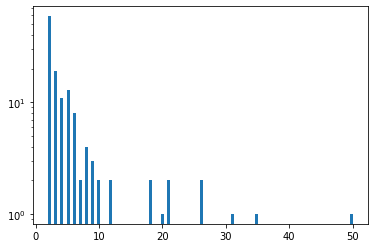

In [305]:
def get_distribution_test(get_distribution):
    path="Henry’s letter.txt"
    test_text = Path(path).read_text().split("\n")
    data=[]
    for text in test_text:
        text = text.lower()
        for char in '-.,\n':
            text = text.replace(char,' ')
        data.append(text)
    
    dist = get_distribution(data)
    test.true(isinstance(dist, collections.Counter))
    if dist is None:
        return

    test.equal(len(dist), 133)
    test.equal(dist['you'], 35)
    test.equal(dist['clare'], 8)
    test.equal(dist['like'], 8)
    test.equal(dist['i'], 50)

@test
def get_distribution(data):
    """ Calculates the word count distribution.

    args: 
        data -- the cleaned data

    return : collections.Counter -- the distribution of word counts
    """
    counter=collections.Counter()
    for text in data:
        counter += collections.Counter(text.lower().split())
    keys=[]
    for key,value in counter.items():
        if value==1:
            keys.append(key)
    for key in keys:
        del counter[key]
    plt.hist(counter.values(), bins=100)
    plt.yscale('log')
    return counter

####  Most Frequent Words
Now let's create a bar chart to display the frequency of words in a descending order using the plot method of Pandas DataFrame and Matplotlib.

If you take search engines course(11-442/642), you might get to know Zipf’s Law which indicate a statistical property of text:
$$P(t_R)=\frac {ctf_{t_R}}{N} \approx \frac {A}{R}$$
$P(t_R)$ is maximum likelihood estimation probability of observing the R'th ranked term in corpus C; ${ctf_{t_R}}$ is the Collection term frequency of the R'th ranked term; $A$ is a constant that different for different languages, $A \approx 0.1$ for English; $N$ is the total word occurrences in corpus C.

So, the probability of the 4 most frequent terms will be:
* $P(t_1)=\frac {0.1}{1} = 0.100$, (10% of the collection)
* $P(t_2)=\frac {0.1}{2} = 0.050$, (5% of the collection)
* $P(t_3)=\frac {0.1}{3} = 0.033$, (3.3% of the collection)
* $P(t_4)=\frac {0.1}{4} = 0.025$, (2.5% of the collection)

Based on this, you can easliy calulate that the 20 most frequent terms are 36.0% of word occurrences, which are very representative. Therefore, in the bar chart, you need to display the 20 most frequent terms in each dataset.

In [310]:
def get_top_freq(dist):
    freq = pd.DataFrame.from_dict(dist, orient='index',columns=['count'])
    plt.figure(figsize=(20,30), dpi=80)
    freq[:30].sort_values(by=['count'],ascending=False).plot.bar()
    plt.xticks(rotation=50)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

<Figure size 1600x2400 with 0 Axes>

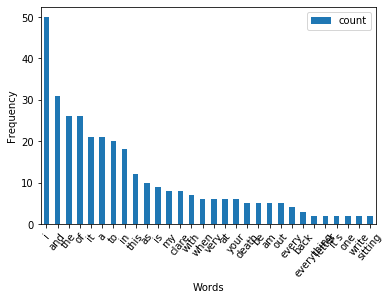

In [311]:
get_top_freq(c)

####  Word Cloud
WordCloud is a technique to show which words are the most frequent among the given text. You can see worldcloud in many places nowadays since it is very intuitive.
Let's create and generate wordcloud images for words in these three sources.

In [119]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [120]:
def get_WordCloud(data):
    text = "".join(d for d in data)
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

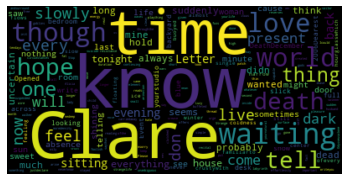

In [123]:
get_WordCloud(test_text)